# This script test the SLEMI MI estimation, bin estimation as well as latest standardized permutation MI
# Major conclusion:
- SLEMI aims to measure MI with fractural input, thus seems inappropriate for EEG-EMG connectivity
- Bin estimation is inaccurate for dynamic system according to litteratures
- SPMI inserts time-series information with respect to Bin estimation
# Linking to EEG-EMG connectivity
Bin estimation and SPMI shall be good candidates in EEG-EMG project
## useful links:
- SPMI applying on Frontal–temporal functional connectivity of EEG: https://link.springer.com/article/10.1007/s11571-019-09553-w
- Permutation entropy: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.88.174102
- Estimating MI with k-nearest neighbour distances: https://arxiv.org/pdf/cond-mat/0305641.pdf
- SPMI regarding to PAC: https://arxiv.org/pdf/cond-mat/0305641.pdf
- Permutation entropy in plain english: https://www.aptech.com/blog/permutation-entropy/
- On the automatic parameter selection for permutation entropy: https://aip.scitation.org/doi/10.1063/1.5111719
# Additional notes
## Arima model in time series forecasting: AutoRegressive Integrated Moving Average
Comparison:  While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. The term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. To make a series stationary, the most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed. ‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. And ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model. Links: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# Implementing details
two types of ordinal pattern distribution are implemented: for single time series and for joint variables via  Keller coding scheme.

SPMI are implemented as HX+HY-HXY

Relative SPMI is defined as (HX+HY-HXY)/max(HX,HY),PLEASE NOTE that this is not widly used.

In [70]:
#install.packages('devtools') run once
# The installation has encounter several problems, please be careful
# library('devtools')
# install_github("sysbiosig/SLEMI")
# install.packages('statcomp')
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install(version = "3.11")
BiocManager::install('OmicsMarkeR')

Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.1 (2020-06-06)

Installing package(s) 'OmicsMarkeR'

also installing the dependencies 'shape', 'bitops', 'assertive.properties', 'assertive.types', 'assertive.numbers', 'assertive.strings', 'assertive.datetimes', 'assertive.files', 'assertive.sets', 'assertive.matrices', 'assertive.models', 'assertive.data', 'assertive.data.uk', 'assertive.data.us', 'assertive.reflection', 'assertive.code', 'DiscriMiner', 'randomForest', 'gbm', 'pamr', 'glmnet', 'caTools', 'permute', 'assertive', 'assertive.base'




package 'shape' successfully unpacked and MD5 sums checked
package 'bitops' successfully unpacked and MD5 sums checked
package 'assertive.properties' successfully unpacked and MD5 sums checked
package 'assertive.types' successfully unpacked and MD5 sums checked
package 'assertive.numbers' successfully unpacked and MD5 sums checked
package 'assertive.strings' successfully unpacked and MD5 sums checked
package 'assertive.datetimes' successfully unpacked and MD5 sums checked
package 'assertive.files' successfully unpacked and MD5 sums checked
package 'assertive.sets' successfully unpacked and MD5 sums checked
package 'assertive.matrices' successfully unpacked and MD5 sums checked
package 'assertive.models' successfully unpacked and MD5 sums checked
package 'assertive.data' successfully unpacked and MD5 sums checked
package 'assertive.data.uk' successfully unpacked and MD5 sums checked
package 'assertive.data.us' successfully unpacked and MD5 sums checked
package 'assertive.reflection' suc

Old packages: 'backports', 'survival'



[1] 0.9516539

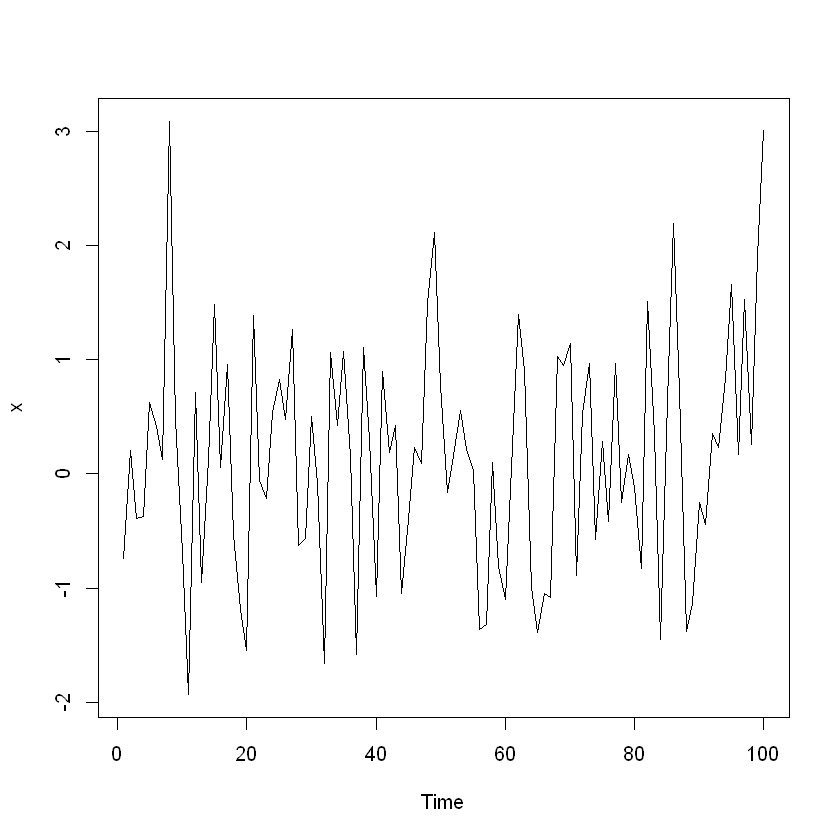

In [21]:
# illustration of permutation entropy, the smaller PE is, the more deterministic the time series are
library('statcomp')
x=arima.sim(model=list(ar=0.3),n=10^2)
plot(x)
opd = ordinal_pattern_distribution(x = x, ndemb = 4) #ndemb: embedding dimension
permutation_entropy(opd)

[1] 0.3025604

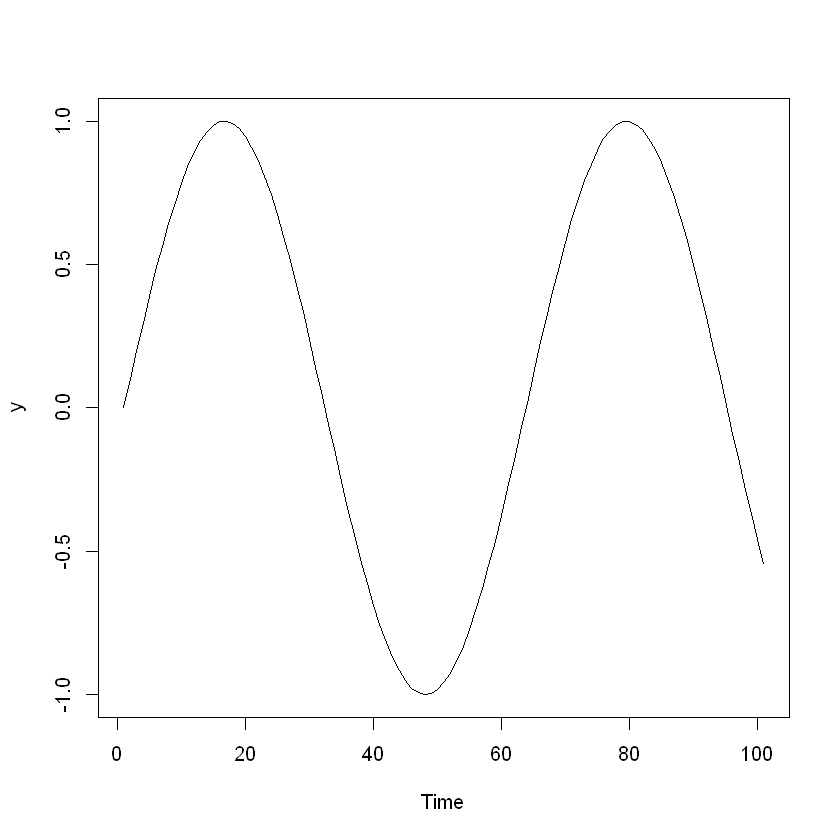

In [20]:
t=seq(0,10,0.1)
y=ts(sin(t))
plot(y)
opd = ordinal_pattern_distribution(x = y, ndemb = 4) #ndemb: embedding dimension
permutation_entropy(opd)

In [51]:
# The calculating procedure
# Considering the time serie S = {4,7,8,5,6}, length = T
# use tao (embedding time, =1 in this example) and D (embedding dimension, =3 in this example)
# The partition is 
# [4 7 8
#  7 8 5
#  8 5 6]
# To find the ordinal patterns (unique permutations that capture the ordinal rankings of the data), 
# D! possible permutations
# p1 {0,1,2}
# p2 {0,2,1}
# p3 {1,2,0}
# p4 {1,0,2}
# p5 {2,1,0}
# p6 {2,0,1}
# The partition is transformed into a permutation matrix
# [0 1 2
#  1 2 0
#  2 0 1]
# Calculating the relative frequencies
# number of occurrence = T-(D-1)*tao = 3
# p1 = 1/3
# p3 = 1/3
# p6 = 1/3
#PE = -sum_{1toD!}(1/3)ln(1/3)
PE_theory=-3*1/3*log(1/3)/log(6)
print(PE_theory)
x = c(4,7,8,5,6)
opd = ordinal_pattern_distribution(x = x, ndemb = 3)
permutation_entropy(opd)

[1] 0.6131472


[1] 0.6131472

In [87]:
# Customize the joint opd
## parameters
# x:= matrix of number of signal*time series length
# only for ndemb>=3
library('OmicsMarkeR')
# x=matrix(1:10,nrow=2,ncol=5)
#x=t(create.random.matrix(2,10, st.dev = 1, perturb = 0.2))
# x=matrix(c(1,4,2,2.1,2.2,2.3,3,3.1,3,4,6,5),nrow=2,ncol=6)
# print(x)
# ndemb = 3

#opd_time_series
ordinal_pattern_distribution = function(x, ndemb) {
  
  ### Deal with gaps in the sliding window time series:
  # get indices to run through for calculation of complexity measures
  gapfree = stats::na.omit(sapply(1:(length(x)-ndemb + 1), FUN = function(y) if(!any(is.na(x[y:(y+ndemb-1)]))) return(y) else return(NA)))
  
  epsilon=1.e-10
  npdim=factorial(ndemb)
  
  #Berechnungs der Ordnungsstatistik nach der Kodierung von Karsten Keller:
  #Physica A 356 (2005) 114-120
  
  ifrec = numeric(length=npdim)  #ersetzt die for-schleife zum erstellen des Vektors, #for ip=1:npdim; ifrec( ip ) = 0; end;
  
  ## introduce for loop:
  for (nv in 1:(length(gapfree))) {
    
    xvec <- x[gapfree[nv]:(gapfree[nv] + ndemb - 1)]
    
    ## only if no gaps are in the "word" of the time series:
    ipa = matrix(data=0,nrow=ndemb, ncol=ndemb)  #Inversionsmatrix
    
    for (il in 2:ndemb) {
      for (it in il:ndemb) { 
        ipa[it, il] = ipa[it-1, il-1]
        if( (xvec[it] <= xvec[it - ( il - 1 ) ] ) || ( abs( xvec[it - ( il - 1)] - xvec[it]) < epsilon))
          ipa[ it, il ] = ipa[ it, il ] + 1;
      }
    }
    
    nd = ipa[ndemb,2] 
    for (il in 3:ndemb) {
      nd =il * nd + ipa[ndemb, il]
    }
    
    ifrec[nd + 1] = ifrec[nd+ 1] + 1;       
  }
  
  # ifrec is the ordinal pattern distribution in the Keller coding scheme!
  return(ifrec)
}

#opd_joint
ordinal_pattern_distribution_joint=function(x,ndemb){
epsilon=1.e-10
npdim=factorial(ndemb)
ifrec = numeric(length=npdim)
gapfree_x = stats::na.omit(sapply(1:(length(x[c(1),])-ndemb + 1), FUN = function(y) if(!any(is.na(x[c(1),][y:(y+ndemb-1)]))) return(y) else return(NA)))
gapfree_y = stats::na.omit(sapply(1:(length(x[c(2),])-ndemb + 1), FUN = function(y) if(!any(is.na(x[c(2),][y:(y+ndemb-1)]))) return(y) else return(NA)))
gapfree_xy = vector(length=length(gapfree_x))
for (gap_id in 1:length(gapfree_x)){
    if (gapfree_x[gap_id] == gapfree_y[gap_id]){
        gapfree_xy[gap_id]=gapfree_x[gap_id]
    }
}
for (nv in 1:(length(gapfree_xy))) {
    xmat <- x[,gapfree_xy[nv]:(gapfree_xy[nv] + ndemb - 1)]
    xvec=as.vector(xmat)

    ## only if no gaps are in the "word" of the time series:
    ipa = matrix(data=0,nrow=ndemb, ncol=ndemb)  #Inversionsmatrix

    for (il in 2:ndemb) {
      for (it in il:ndemb) { 
        ipa[it, il] = ipa[it-1, il-1]
        if( (xvec[it] <= xvec[it - ( il - 1 ) ] ) || ( abs( xvec[it - ( il - 1)] - xvec[it]) < epsilon))
          ipa[ it, il ] = ipa[ it, il ] + 1;
  }
}
    nd = ipa[ndemb,2] 
    for (il in 3:ndemb) {
        nd =il * nd + ipa[ndemb, il]
    }
    
    ifrec[nd + 1] = ifrec[nd+ 1] + 1;       
  }
return(ifrec)
                                  }
                                  
shannon_entropy = function(opd) {
  opd.prob = opd / sum(opd)
  H_s = (-1) * sum(sapply(opd.prob, FUN=function(prob) if (prob >= 1.e-30) return(prob * log(prob)) else return(0)))
  return(H_s)
}
                          
# Permutation MI
SPMI=function(x,ndemb){
    X=x[c(1),]
    Y=x[c(2),]
    HX=shannon_entropy(ordinal_pattern_distribution(X,ndemb))
    HY=shannon_entropy(ordinal_pattern_distribution(Y,ndemb))
    HXY=shannon_entropy(ordinal_pattern_distribution_joint(x,ndemb))
    return (HX+HY-HXY)
}

# regularized Permutation MI - consult Gansheng TAN for further theorectical details
regularized_SPMI=function(x,ndemb){
    X=x[c(1),]
    Y=x[c(2),]
    HX=shannon_entropy(ordinal_pattern_distribution(X,ndemb))
    HY=shannon_entropy(ordinal_pattern_distribution(Y,ndemb))
    HXY=shannon_entropy(ordinal_pattern_distribution_joint(x,ndemb))
    return ((HX+HY-HXY)/max(HX,HY))
}


     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    1  2.0  2.2  3.0    3    6
[2,]    4  2.1  2.3  3.1    4    5


In [103]:
# Test cell
#ndemb is set to 3
x=matrix(c(1,4,2,2.1,2.2,2.3,3,3.1,3.2,4,6,5),nrow=2,ncol=6)
print(x)
# In this cell, the opd for X (strictly increasing) is (4,0,0,0,0,0) 
print(x[c(1),])
opd_X=ordinal_pattern_distribution(x[c(1),],3)
cat('opd of X is ',opd_X,'\n')
cat('PE of X is ',shannon_entropy(opd_X),'\n')
# For Y, it is 3 0 1 0 0 0, only (4,2.1,2.3) is an exception
print(x[c(2),])
opd_Y = ordinal_pattern_distribution(x[c(2),],3)
print(opd_Y)
print(shannon_entropy(opd_Y))
# For the joint PE
opd_XY=ordinal_pattern_distribution_joint(x,3)
print(opd_XY)
print(shannon_entropy(opd_XY))
# Thus the final decrease of PE_X is 0 
SPMI(x,3)

     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    1  2.0  2.2  3.0  3.2    6
[2,]    4  2.1  2.3  3.1  4.0    5
[1] 1.0 2.0 2.2 3.0 3.2 6.0
opd of X is  4 0 0 0 0 0 
PE of X is  0 
[1] 4.0 2.1 2.3 3.1 4.0 5.0
[1] 3 0 1 0 0 0
[1] 0.5623351
[1] 3 0 0 1 0 0
[1] 0.5623351


[1] 0

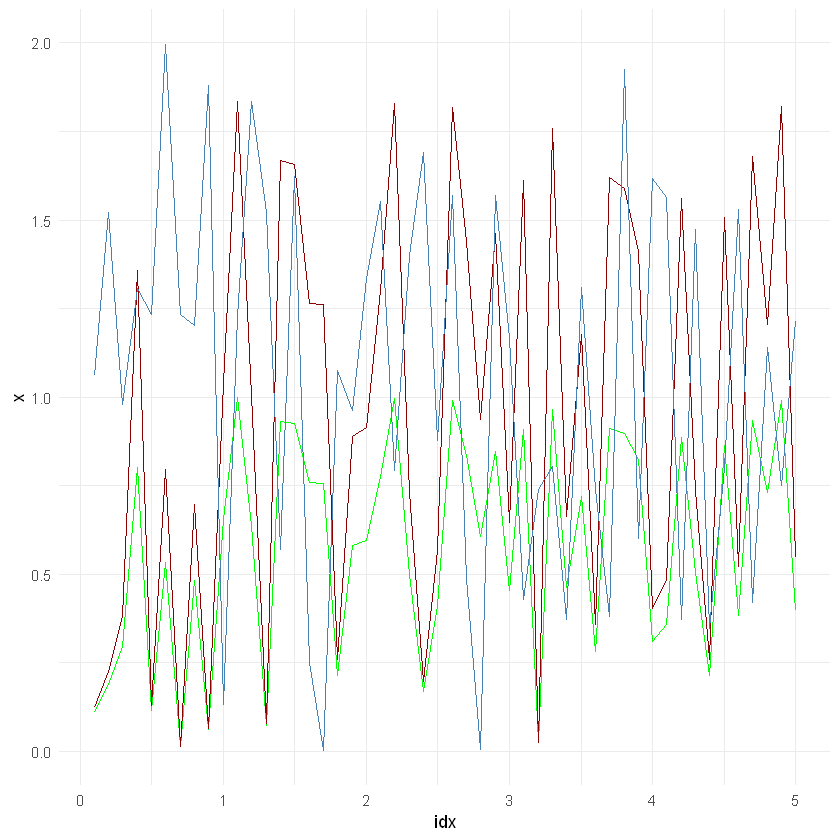

In [151]:
# Comparison of the SPMI for dependent variables and pseudo-unrelated variables
# Green is x, dependent ys are represented red and independent ys are represented by blue line
x <- runif(50, 0.0, 1.0)
y_ind =runif(50, 0.0, 2.0)
y_d = x^2+sin(x)
t=seq(0.1,5,0.1)
dat=matrix(c(t,x,y_d,y_ind),ncol=4)
df=as.data.frame(dat)
library('ggplot2')
theme_set(theme_minimal())
colnames(df) <- c("idx","x", "dependent_y","independent_y")
# df
ggplot(data = df, aes(x=idx))+
geom_line(aes(y=x),color="green")+
geom_line(aes(y=dependent_y),color="darkred")+
geom_line(aes(y=independent_y),color="steelblue")
ggsave("myplot.pdf",width=8,height=4)
# matplot(dat,type='l',col=1:3)
# legend('topleft',legend=c('x','dependent y','ind y'),col=1:3,pch=1)

In [149]:
#Comparison of the SPMI
dat = t(matrix(c(x,y_d),ncol=2))
print(SPMI(dat,3))
dat = matrix(c(x,y_ind),nrow=2)
print(SPMI(dat,3))
#Conclusion high dependent variables have higher SPMI

[1] 2.544242
[1] 1.653674


# Test script for python implementation

In [21]:
x = c(1,2,3,4,5,6,7,8,9)
ndemb = 3 
gapfree = stats::na.omit(sapply(1:(length(x)-ndemb + 1), FUN = function(y) if(!any(is.na(x[y:(y+ndemb-1)]))) return(y) else return(NA)))
# gapfree = the onset index for vector x
# 1:(length(x)-ndemb + 1): possible index, maybe contains NA
# We will not have NA, so we could ignore that in the reimplementation
npdim=factorial(ndemb)
ifrec = numeric(length=npdim)

for (nv in 1:(length(gapfree))) {    
    xvec <- x[gapfree[nv]:(gapfree[nv] + ndemb - 1)]}
gapfree[1]:(gapfree[1] + ndemb - 1)

[1] 1 2 3

# Envelop
## Something about the analytic signal and the analytic envelope
The analytic representation of a real-valued function is an analytic signal, comprising the original function and its Hilbert transform. This representation facilitates many mathematical manipulations. The basic idea is that the negative frequency components of the Fourier transform (or spectrum) of a real-valued function are superfluous, due to the Hermitian symmetry of such a spectrum. These negative frequency components can be discarded with no loss of information, provided one is willing to deal with a complex-valued function instead. That makes certain attributes of the function more accessible and facilitates the derivation of modulation and demodulation techniques, such as single-sideband.
